In [ ]:
#

In [ ]:
import torch
print(torch.cuda.get_device_name(0))
torch.cuda.is_available()

GeForce RTX 3070 Laptop GPU


True

In [ ]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tqdm import tqdm

import pandas as pd
import numpy as np
import random
import time
import datetime
import re
import matplotlib.pyplot as plt

In [ ]:
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
GeForce RTX 3070 Laptop GPU


In [ ]:
f0 = pd.read_excel('C:/Users/Leofold/_Python/_Python_LSTM/tagging seting 5.xlsx')

In [ ]:
f00 = f0

In [ ]:
f00.head()

,Index,Order,ID,Date,Comment,CommentLikes,Comment_morphs_A,Comment_morphs_N,CommentLikes.1,Video type,...,Economy_Classification,Nation_Policy,Nation_SocialEnviron,Job,Housing,Instrumentalism,Competition,Classification,Policy,SocialEnvironment
0,0,926,HomeSweetHome,5개월 전,닭들이 알낳으면 양계장 주인만 존나 좋아하지않냐? 그게 딱 한국 현실이여,17000,"['닭', '들', '이', '알', '낳다', '양', '계장', '주인', '만...","['닭', '알', '계장', '주인', '존나', '그게', '한국', '현실']",17000,SBS_11063,...,1,0,1,0,0,17000,0,17000,0,17000
1,1,10311,오승진,8개월전,나는 평생 집은 커녕 화장실도 못살꺼같으니 많이 해드신 LH직원분들이랑 국회위원분들...,16000,"['나', '는', '평생', '집은', '커녕', '화장실', '도', '못', ...","['나', '평생', '커녕', '화장실', '해', '직원', '국회', '위원'...",16000,YTN_7306%13855,...,1,0,1,0,16000,16000,0,16000,0,16000
2,2,3010,ᄋᄃᄂ,@성이름,육아휴직이나 받아주던가 경력단절이나 없던가 월급이나 많던가 교육비나 적던가 내집마련...,15000,"['육아휴직', '이나', '받다', '경력', '단절', '이나', '없다', '...","['육아휴직', '경력', '단절', '월급', '교육비', '내집마련', '단',...",15000,SBS_11063,...,1,1,1,15000,15000,0,15000,15000,15000,15000
3,3,52917,killbill,10개월전,나라가 망하는게 문제가 아니라내가 죽게 생겼다,12000,"['나라', '가', '망하는게', '문제', '가', '아니라', '내', '가'...","['나라', '문제', '내']",12000,YTN_4447%10647,...,0,0,1,0,0,0,0,0,0,12000
4,4,487,박건이,1개월 전,현재: 제발 애좀 낳으세요 물론 양육비는 처음부터 끝까지 느그가 알아서 하셈 ^^,12000,"['현재', ':', '제발', '애좀', '낳다', '물론', '양육비', '는'...","['현재', '제발', '애좀', '양육비', '처음', '끝', '느그', '셈']",12000,MBC_6913,...,0,1,1,0,0,12000,0,0,12000,12000


In [ ]:
f00.tail()

,Index,Order,ID,Date,Comment,CommentLikes,Comment_morphs_A,Comment_morphs_N,CommentLikes.1,Video type,...,Economy_Classification,Nation_Policy,Nation_SocialEnviron,Job,Housing,Instrumentalism,Competition,Classification,Policy,SocialEnvironment
89596,89596,2328,이재오,1년 전,댓글들 애 안 낳는걸로 시위하나ㅋㅋㅋㅋ꼬라지 봐라,0,"['댓글', '들', '애', '안', '낳다', '는걸', '로', '시위', '...","['댓글', '애', '안', '는걸', '시위', '하나', '꼬']",0,SBS_3196,...,0,0,1,1,1,1,1,1,1,1
89597,89597,3066,YuwonSong,@昇神風,뭔가 오해하는 사람이 많아보이는데... 해당 뉴스 클립에선 돈이 전부가 아니니까 불...,0,"['뭔가', '오해', '하다', '사람', '이', '많다', '보이다', '.....","['뭔가', '오해', '사람', '해당', '뉴스', '클립', '돈', '전부'...",0,SBS_3196,...,1,1,1,1,1,1,1,1,1,1
89598,89598,2555,Merak,1년 전,나만 근본원인을 알지.ㅋㅋ 공무원들은 몰라. 자기들 연금때문에 모른척하나?,0,"['나', '만', '근', '본', '원인', '을', '알', '지', '.',...","['나', '원인', '알', '공무원', '자기', '연금', '때문', '척']",0,SBS_3196,...,0,0,1,1,1,1,1,1,1,1
89599,89599,2554,드래곤로드,1년 전,@집가고싶다 집 값 너무 비싸서 못사서요ㅠㅠ.. 그래서 결혼 안함..ㅋㅋㅋ......,0,"['집', '값', '너무', '비싸다', '못', '사다', 'ㅠㅠ', '..',...","['집', '값', '결혼', '안함', '혼자', '살', '원룸', '살', '...",0,SBS_3196,...,0,0,0,1,1,1,1,1,1,1
89600,89600,58267,kimmmju,1년전(수정됨),진짜 대한민국이 겁나피해의식에 쩔어있구나 나도 애둘있고 연봉 4000만원 조금넘게 ...,0,"['진짜', '대한민국', '이', '겁나', '피해', '의식', '에', '쩔어...","['진짜', '대한민국', '피해', '의식', '애', '연봉', '조금', '좀...",0,YTN_904%1060,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
f00.columns

Index(['Index', 'Order', 'ID', 'Date', 'Comment', 'CommentLikes',
       'Comment_morphs_A', 'Comment_morphs_N', 'CommentLikes.1', 'Video type',
       'Economy_Job', 'Economy_House', 'Neoliberal_Instrumentalism',
       'Neoliberal_Competition', 'Economy_Classification', 'Nation_Policy',
       'Nation_SocialEnviron', 'Job', 'Housing', 'Instrumentalism',
       'Competition', 'Classification', 'Policy', 'SocialEnvironment'],
      dtype='object')

In [ ]:
f01 = f00[['Order', 'Comment',
           
           'Economy_Job', 'Economy_House', 'Neoliberal_Instrumentalism',
       'Neoliberal_Competition', 'Economy_Classification', 'Nation_Policy',
       'Nation_SocialEnviron']]

In [ ]:
f01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89601 entries, 0 to 89600
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Order                       89601 non-null  int64 
 1   Comment                     89601 non-null  object
 2   Economy_Job                 89601 non-null  int64 
 3   Economy_House               89601 non-null  int64 
 4   Neoliberal_Instrumentalism  89601 non-null  int64 
 5   Neoliberal_Competition      89601 non-null  int64 
 6   Economy_Classification      89601 non-null  int64 
 7   Nation_Policy               89601 non-null  int64 
 8   Nation_SocialEnviron        89601 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 6.2+ MB


In [ ]:
f01.columns

Index(['Order', 'Comment', 'Economy_Job', 'Economy_House',
       'Neoliberal_Instrumentalism', 'Neoliberal_Competition',
       'Economy_Classification', 'Nation_Policy', 'Nation_SocialEnviron'],
      dtype='object')

In [ ]:
#data["label"].value_counts()
f01['Economy_House'].value_counts()

0    79061
1    10540
Name: Economy_House, dtype: int64

In [ ]:
f01['Economy_Classification'].value_counts()

0    68210
1    21391
Name: Economy_Classification, dtype: int64

In [ ]:

print(f01['Economy_Job'].value_counts())
print(f01['Economy_House'].value_counts())

print('=====================================================')
print('=====================================================')
print('=====================================================')

print(f01['Neoliberal_Instrumentalism'].value_counts())
print(f01['Neoliberal_Competition'].value_counts())
print(f01['Economy_Classification'].value_counts())

print('=====================================================')
print('=====================================================')
print('=====================================================')

print(f01['Nation_Policy'].value_counts())
print(f01['Nation_SocialEnviron'].value_counts())

0    73141
1    16460
Name: Economy_Job, dtype: int64
0    79061
1    10540
Name: Economy_House, dtype: int64
0    73928
1    15673
Name: Neoliberal_Instrumentalism, dtype: int64
0    74583
1    15018
Name: Neoliberal_Competition, dtype: int64
0    68210
1    21391
Name: Economy_Classification, dtype: int64
0    71311
1    18290
Name: Nation_Policy, dtype: int64
0    45440
1    44161
Name: Nation_SocialEnviron, dtype: int64


In [ ]:
f02 = f01[['Order', 'Comment','Economy_Job']]
f02['Economy_Job'].value_counts()

0    73141
1    16460
Name: Economy_Job, dtype: int64

In [ ]:
f022 = f02

In [ ]:
f022.tail()

,Order,Comment,Economy_Job
89596,2328,댓글들 애 안 낳는걸로 시위하나ㅋㅋㅋㅋ꼬라지 봐라,0
89597,3066,뭔가 오해하는 사람이 많아보이는데... 해당 뉴스 클립에선 돈이 전부가 아니니까 불...,1
89598,2555,나만 근본원인을 알지.ㅋㅋ 공무원들은 몰라. 자기들 연금때문에 모른척하나?,0
89599,2554,@집가고싶다 집 값 너무 비싸서 못사서요ㅠㅠ.. 그래서 결혼 안함..ㅋㅋㅋ......,0
89600,58267,진짜 대한민국이 겁나피해의식에 쩔어있구나 나도 애둘있고 연봉 4000만원 조금넘게 ...,1


In [ ]:
f022.columns = ['id', 'document', 'label']

In [ ]:
f022['label'].value_counts()

0    73141
1    16460
Name: label, dtype: int64

In [ ]:
f022.tail()

,id,document,label
89596,2328,댓글들 애 안 낳는걸로 시위하나ㅋㅋㅋㅋ꼬라지 봐라,0
89597,3066,뭔가 오해하는 사람이 많아보이는데... 해당 뉴스 클립에선 돈이 전부가 아니니까 불...,1
89598,2555,나만 근본원인을 알지.ㅋㅋ 공무원들은 몰라. 자기들 연금때문에 모른척하나?,0
89599,2554,@집가고싶다 집 값 너무 비싸서 못사서요ㅠㅠ.. 그래서 결혼 안함..ㅋㅋㅋ......,0
89600,58267,진짜 대한민국이 겁나피해의식에 쩔어있구나 나도 애둘있고 연봉 4000만원 조금넘게 ...,1


In [ ]:
f022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89601 entries, 0 to 89600
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        89601 non-null  int64 
 1   document  89601 non-null  object
 2   label     89601 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


In [ ]:
data = f022
data.tail()

,id,document,label
89596,2328,댓글들 애 안 낳는걸로 시위하나ㅋㅋㅋㅋ꼬라지 봐라,0
89597,3066,뭔가 오해하는 사람이 많아보이는데... 해당 뉴스 클립에선 돈이 전부가 아니니까 불...,1
89598,2555,나만 근본원인을 알지.ㅋㅋ 공무원들은 몰라. 자기들 연금때문에 모른척하나?,0
89599,2554,@집가고싶다 집 값 너무 비싸서 못사서요ㅠㅠ.. 그래서 결혼 안함..ㅋㅋㅋ......,0
89600,58267,진짜 대한민국이 겁나피해의식에 쩔어있구나 나도 애둘있고 연봉 4000만원 조금넘게 ...,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89601 entries, 0 to 89600
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        89601 non-null  int64 
 1   document  89601 non-null  object
 2   label     89601 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


In [ ]:
print(len(data), ': All document count')

89601 : All document count


In [ ]:
#

In [ ]:
def print_plot(data, label):
    n_total = len(data)
    n_zero = len(data.query(label + ' == 0'))
    n_one = len(data.query(label + ' == 1'))

    print("label 0 : {}개, {:.2f}%".format(n_zero, n_zero*100/n_total))
    print("label 1 : {}개, {:.2f}%\n".format(n_one, n_one*100/n_total))

    values = data[label].value_counts()
    values.plot(kind='bar')
    print(values)

label 0 : 73141개, 81.63%
label 1 : 16460개, 18.37%

0    73141
1    16460
Name: label, dtype: int64


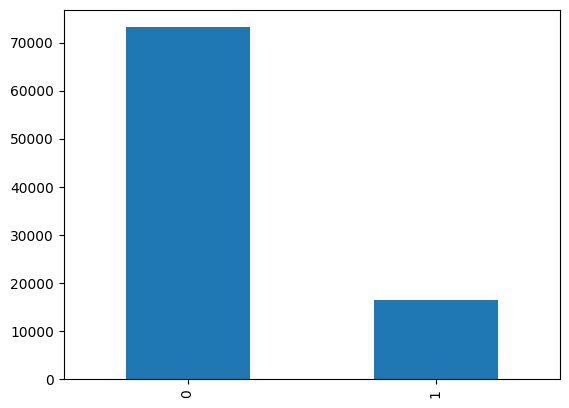

In [ ]:
print_plot(data, 'label')

In [ ]:
data00 = data

In [ ]:
print(len(data00))

data0 = data00.drop_duplicates()
print(len(data0))
print(len(data00))

89601
89601
89601


In [ ]:
data_test_0 = data0['label'] == 0
print('data[data_test_0]의 길이 : ',len(data0[data_test_0]))
train, test = train_test_split(data0[data_test_0], random_state=42,test_size=0.0412)
print(len(train), 'train examples')
print(len(test), 'test examples')

data_test_f_0 = test
data_ori_0= train
print('data_ori_0의 길이 : ',len(data_ori_0))

data[data_test_0]의 길이 :  73141
70127 train examples
3014 test examples
data_ori_0의 길이 :  70127


In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

data_test_1 = data0['label'] == 1
print('data[data_test_1]의 길이 : ',len(data0[data_test_1]))
train, test = train_test_split(data0[data_test_1], random_state=42,test_size=0.183)
print(len(train), 'train examples')
print(len(test), 'test examples')

data_test_f_1 = test
data_ori_1= train
print('data_ori_1의 길이 : ',len(data_ori_1))

data[data_test_1]의 길이 :  16460
13447 train examples
3013 test examples
data_ori_1의 길이 :  13447


test_test 크기 :  6027
0    3014
1    3013
Name: label, dtype: int64
label 0 : 3014개, 50.01%
label 1 : 3013개, 49.99%

0    3014
1    3013
Name: label, dtype: int64


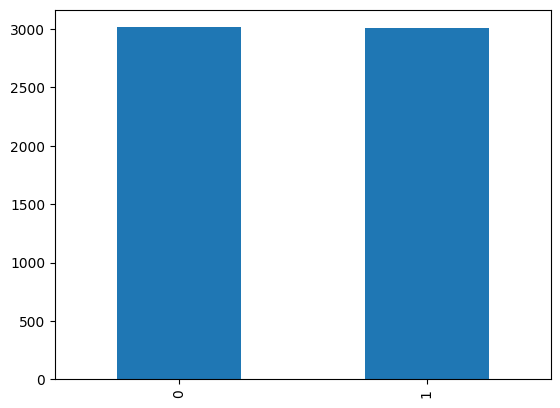

In [ ]:
test_test = pd.concat([data_test_f_0,data_test_f_1], ignore_index=True,axis=0)
print('test_test 크기 : ',len(test_test))
print(test_test['label'].value_counts())
print_plot(test_test, 'label')

train_all 크기 :  83574
0    70127
1    13447
Name: label, dtype: int64
label 0 : 70127개, 83.91%
label 1 : 13447개, 16.09%

0    70127
1    13447
Name: label, dtype: int64


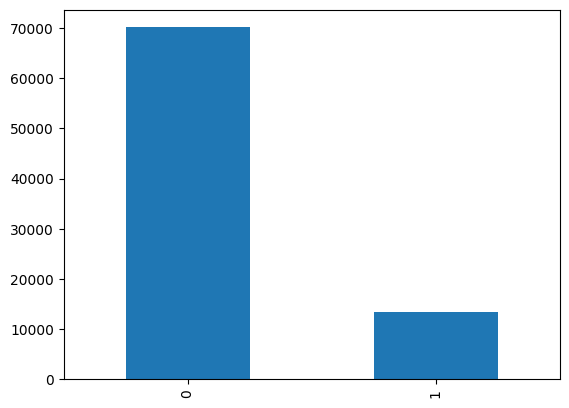

In [ ]:
train_all = pd.concat([data_ori_1,data_ori_0], ignore_index=True,axis=0)
print('train_all 크기 : ',len(train_all))
print(train_all['label'].value_counts())
print_plot(train_all, 'label')

In [ ]:
train_all

,id,document,label
0,56603,일자리만 드럽게 많이 만들면 취직 잘 되겠지? 생각하는 의원 좀 삭감했으면 좋겠음,1
1,1025,@김바보 월급세후 400가까이 되어도 희망이없어요. 문재인이 이후로 월급조금더 ...,1
2,1254,@昇神風 진짜 죄송한데 무슨 직업가지시고 이름은 무엇이고 얼마나 버는 분이세요?...,1
3,1083,그냥 돈벌어서 모아서 이 나라를 뜨고싶네요 좋은 나라가서 아이낳고 살고싶어요 금수저...,1
4,31503,@김형섭 이 사람 글은 계약직인게 불만이 아니라 이래서 안 낳는다는거지,1
...,...,...,...
83569,28169,애낳기 좋은 환경 갖춰져있으면 뭐라안해도 사람들이 출산하는데 그 환경을 안만들어주니...,0
83570,954,여성가x부랑 문제인이한테 물어보셈,0
83571,9805,출산율이 어떻게 마이너스야 ㅋㅋㅋ 가만히 있는 태아 다 죽는거냐 ㅋㅋㅋㅋ,0
83572,4678,@늙고병든젊은이 존나 눈치없네,0


In [ ]:
train_all = train_all.sample(frac=1).reset_index(drop=True)
train_all

,id,document,label
0,36469,"한국은 500년간 세뇌된 유교적 핏줄,조상 중시 . _x000D_서양은 20살이면 ...",1
1,1906,ㅅㅂ 면도날하나에 4만원하는건 뭔심보인지...,0
2,40406,인정합니다. 살 권리가 있는 것과 마찬가지로 죽을 권리도 있는 것입니다.,0
3,4559,경제가 살아나고 숨통이 트여야 자연스럽게 출산율은 올라가는거다..,1
4,43265,저출산대책 쓴 모든기관 내역 조사해라,0
...,...,...,...
83569,13328,@ᄋ억만장자 뇌절 ㄴ,0
83570,23310,서울도 인구증감율이 00년도에 비하면 20년도에 50배 줄엇는데...의식주에서 주...,1
83571,48531,"집값은 치솟고, 일자리는 줄어들고 무한경쟁에서 승리하는 오로지 상위 0.1프로만이 ...",1
83572,27259,@Hillagoon 님이 말하는건 같은 언어권에서만 되는거구요 언어가 다른데 대...,0


In [ ]:
data_ori_1

,id,document,label
12404,56603,일자리만 드럽게 많이 만들면 취직 잘 되겠지? 생각하는 의원 좀 삭감했으면 좋겠음,1
9819,1025,@김바보 월급세후 400가까이 되어도 희망이없어요. 문재인이 이후로 월급조금더 ...,1
12949,1254,@昇神風 진짜 죄송한데 무슨 직업가지시고 이름은 무엇이고 얼마나 버는 분이세요?...,1
80327,1083,그냥 돈벌어서 모아서 이 나라를 뜨고싶네요 좋은 나라가서 아이낳고 살고싶어요 금수저...,1
53573,31503,@김형섭 이 사람 글은 계약직인게 불만이 아니라 이래서 안 낳는다는거지,1
...,...,...,...
60504,21757,집생각하면 결혼포기하는게맞지 세상 지금 할게얼마나많은데 남은평생 집값갚고 자식키우는...,1
64210,9567,돈이랑 집이 있어야 결혼을 하고 아이을 키우지,1
28329,32137,@GYEONG SEOB Jo 상식적으로 생각해보면 '자식을 적게낳는게 나쁜짓이고...,1
4056,26796,"지금 이 영상의 댓글만 대충 훑어봐도 20대 30대 젊음층들의 분노와 멸시로,이 나...",1


In [ ]:
# 전처리

document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train_all.document]
document_bert[:5]

['[CLS] 한국은 500년간 세뇌된 유교적 핏줄,조상 중시 . _x000D_서양은 20살이면 독립 _x000D_오직 한국만 사교육비,등록금,결혼비,손자돌봄... 늙어 죽을때까지 핏줄에게 퍼줌. _x000D_주식회사가 대기업부터 중소기업까지 전부다 핏줄 경영하는 유일한 나라. _x000D_진보,보수 할것 없이 핏줄 퍼주기에 혈안이 되어 있는 나라. _x000D_그래서 힘들어지면 핏줄을 한 운명체로 보고 가족 살해가 매우 흔한 나라. _x000D_핏줄중시로 _x000D_미혼모 왕따,비난,차별 _x000D_동거비율 세계 최저 _x000D_수십년간 해외입양 세계 1위 _x000D_비혼출산 oecd 평균 39%,핏줄 이기주의 한국은 1%_x000D_난임부부들도 핏줄중시로 입양 꺼림. _x000D_서양은 제사 없음._x000D_한국은 명절도 제사(핏줄)로 인해 그 누구도 행복하게 지내지 못하는 나라. _x000D_제사로 핏줄 연결을 끊임없이 각인 시키는 나라!!!!_x000D_핏줄 이기주의 ,핏줄 퍼주기->양육부담 ,양극화, 희망포기->비혼 급증->국가 소멸.. _x000D_성인 야동 금지는 한국이 거의 유일_x000D_야동 ,성매매,유사 성행위 금지_x000D_동성애 , 리얼돌 반대 시위_x000D_얼마전 고등학생들에게 콘돔 사용법 성교육하자 학부모가 항의해서 취소됨_x000D_그저 공부하는 기계로만 학생 키우는 나라_x000D_강제 고자화 시키고 기본 쾌락 말살 시키는 나라_x000D_Oecd 중 공공 정자 은행 없는 유일한 나라_x000D_미국은 한해에 수만명씩 정자 기증으로 태어남._x000D_성이라면 치를 떠는 한국_x000D_성진국 이라고 놀리는 일본은 출산율 1.42명_x000D_성을 감추기만 하는 한국은 출산율 0.92명_x000D_성진국 보다 먼저 소멸될 한국_x000D_중국은 대리모가 활황 , 근데 한국은 다 불법인 나라._x000D_일본인 사유리는 일본에서 합법적으로 정자 기증 받아 미혼모 출산._x000D_근데 한국은 다 불법인 나라!!!!_x0

In [ ]:
# 토크나이징

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(tokenized_texts[0])

['[CLS]', '한국', '##은', '500', '##년', '##간', '세', '##뇌', '##된', '유', '##교', '##적', '[UNK]', ',', '조', '##상', '중', '##시', '.', '_', 'x', '##000', '##D', '_', '서', '##양', '##은', '20', '##살', '##이', '##면', '독', '##립', '_', 'x', '##000', '##D', '_', '오', '##직', '한국', '##만', '사', '##교', '##육', '##비', ',', '등', '##록', '##금', ',', '결', '##혼', '##비', ',', '손', '##자', '##돌', '##봄', '.', '.', '.', '늙', '##어', '죽', '##을', '##때', '##까지', '[UNK]', '퍼', '##줌', '.', '_', 'x', '##000', '##D', '_', '주', '##식', '##회', '##사가', '대', '##기', '##업', '##부터', '중', '##소', '##기', '##업', '##까지', '전', '##부', '##다', '[UNK]', '경', '##영', '##하는', '유', '##일한', '나', '##라', '.', '_', 'x', '##000', '##D', '_', '진', '##보', ',', '보', '##수', '할', '##것', '없이', '[UNK]', '퍼', '##주', '##기에', '혈', '##안', '##이', '되어', '있는', '나', '##라', '.', '_', 'x', '##000', '##D', '_', '그', '##래', '##서', '힘', '##들어', '##지', '##면', '[UNK]', '한', '운', '##명', '##체', '##로', '보고', '가', '##족', '살', '##해', '##가', '매우', '흔', '##한', '나', '##라', '.', '_',

In [ ]:
# 패딩

MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,  48556,  10892,  10757,  10954,  18784,   9435, 118749,
        13441,   9625,  25242,  14801,    100,    117,   9678,  14871,
         9694,  14040,    119,    168,    192,  77802,  11490,    168,
         9425,  37114,  10892,  10197, 106249,  10739,  14867,   9088,
        35115,    168,    192,  77802,  11490,    168,   9580,  33077,
        48556,  19105,   9405,  25242,  83811,  29455,    117,   9121,
        31398,  40032,    117,   8881, 119439,  29455,    117,   9450,
        13764, 118794, 118987,    119,    119,    119,   9045,  12965,
         9690,  10622, 118832,  18382,    100,   9913, 119220,    119,
          168,    192,  77802,  11490,    168,   9689,  21155,  14863,
        49636,   9069,  12310,  26784,  17655,   9694,  22333,  12310,
        26784,  18382,   9665,  14646,  11903,    100,   8885,  30858,
        12178,   9625,  75886,   8982,  17342,    119,    168,    192,
        77802,  11490,    168,   9708,  30005,    117,   9356,  15891,
      

In [ ]:
len(input_ids)

83574

In [ ]:
input_ids

array([[   101,  48556,  10892, ...,  17342,    119,    168],
       [   101,    100,   9279, ...,      0,      0,      0],
       [   101,   9640,  16605, ...,      0,      0,      0],
       ...,
       [   101,   9711, 118611, ...,      0,      0,      0],
       [   101,    137,  12289, ...,      0,      0,      0],
       [   101,    137,   9319, ...,      0,      0,      0]])

In [ ]:
# RDRS

In [ ]:
x1_train = input_ids
x2_train = pd.DataFrame(x1_train)

In [ ]:
x2_train

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,101,48556,10892,10757,10954,18784,9435,118749,13441,9625,...,33797,9979,34951,10739,37909,13767,8982,17342,119,168
1,101,100,9279,12092,41919,35506,16439,10530,125,19105,...,0,0,0,0,0,0,0,0,0,0
2,101,9640,16605,33188,48345,119,9408,8917,44130,13767,...,0,0,0,0,0,0,0,0,0,0
3,101,8885,54480,9408,16985,16439,11664,9464,43022,10739,...,0,0,0,0,0,0,0,0,0,0
4,101,9663,52363,21386,14423,119254,9512,25701,12310,20595,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83569,101,137,100,9030,58931,100,102,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83570,101,48253,12092,110484,119230,105197,119183,10739,11025,10954,...,0,0,0,0,0,0,0,0,0,0
83571,101,9711,118611,10892,9779,119056,11664,117,9641,13764,...,0,0,0,0,0,0,0,0,0,0
83572,101,137,12289,22163,10263,9053,10739,9251,12178,71439,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_all

,id,document,label
0,36469,"한국은 500년간 세뇌된 유교적 핏줄,조상 중시 . _x000D_서양은 20살이면 ...",1
1,1906,ㅅㅂ 면도날하나에 4만원하는건 뭔심보인지...,0
2,40406,인정합니다. 살 권리가 있는 것과 마찬가지로 죽을 권리도 있는 것입니다.,0
3,4559,경제가 살아나고 숨통이 트여야 자연스럽게 출산율은 올라가는거다..,1
4,43265,저출산대책 쓴 모든기관 내역 조사해라,0
...,...,...,...
83569,13328,@ᄋ억만장자 뇌절 ㄴ,0
83570,23310,서울도 인구증감율이 00년도에 비하면 20년도에 50배 줄엇는데...의식주에서 주...,1
83571,48531,"집값은 치솟고, 일자리는 줄어들고 무한경쟁에서 승리하는 오로지 상위 0.1프로만이 ...",1
83572,27259,@Hillagoon 님이 말하는건 같은 언어권에서만 되는거구요 언어가 다른데 대...,0


In [ ]:
pdTrain_all = pd.concat([x2_train,train_all['label']], ignore_index=True,axis=1)
pdTrain_all

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,101,48556,10892,10757,10954,18784,9435,118749,13441,9625,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
1,101,100,9279,12092,41919,35506,16439,10530,125,19105,...,0,0,0,0,0,0,0,0,0,0
2,101,9640,16605,33188,48345,119,9408,8917,44130,13767,...,0,0,0,0,0,0,0,0,0,0
3,101,8885,54480,9408,16985,16439,11664,9464,43022,10739,...,0,0,0,0,0,0,0,0,0,1
4,101,9663,52363,21386,14423,119254,9512,25701,12310,20595,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83569,101,137,100,9030,58931,100,102,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83570,101,48253,12092,110484,119230,105197,119183,10739,11025,10954,...,0,0,0,0,0,0,0,0,0,1
83571,101,9711,118611,10892,9779,119056,11664,117,9641,13764,...,0,0,0,0,0,0,0,0,0,1
83572,101,137,12289,22163,10263,9053,10739,9251,12178,71439,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pdTrain_all = pdTrain_all.rename(columns={128:'label'})
pdTrain_all

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,101,48556,10892,10757,10954,18784,9435,118749,13441,9625,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
1,101,100,9279,12092,41919,35506,16439,10530,125,19105,...,0,0,0,0,0,0,0,0,0,0
2,101,9640,16605,33188,48345,119,9408,8917,44130,13767,...,0,0,0,0,0,0,0,0,0,0
3,101,8885,54480,9408,16985,16439,11664,9464,43022,10739,...,0,0,0,0,0,0,0,0,0,1
4,101,9663,52363,21386,14423,119254,9512,25701,12310,20595,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83569,101,137,100,9030,58931,100,102,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83570,101,48253,12092,110484,119230,105197,119183,10739,11025,10954,...,0,0,0,0,0,0,0,0,0,1
83571,101,9711,118611,10892,9779,119056,11664,117,9641,13764,...,0,0,0,0,0,0,0,0,0,1
83572,101,137,12289,22163,10263,9053,10739,9251,12178,71439,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pdTrain_0 = pdTrain_all['label'] == 0
print('0의 길이 : ',len(pdTrain_all[pdTrain_0]))

pdTrain_0 = pdTrain_all[pdTrain_0]
print(len(pdTrain_0))
pdTrain_0

0의 길이 :  70127
70127


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
1,101,100,9279,12092,41919,35506,16439,10530,125,19105,...,0,0,0,0,0,0,0,0,0,0
2,101,9640,16605,33188,48345,119,9408,8917,44130,13767,...,0,0,0,0,0,0,0,0,0,0
4,101,9663,52363,21386,14423,119254,9512,25701,12310,20595,...,0,0,0,0,0,0,0,0,0,0
5,101,9663,41521,9056,9638,36553,70930,12424,8924,56710,...,0,0,0,0,0,0,0,0,0,0
6,101,137,9580,22695,123,16323,93867,100,9065,16439,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83567,101,137,8868,16605,8984,9532,57030,10530,9379,33305,...,0,0,0,0,0,0,0,0,0,0
83568,101,9663,52363,21386,9269,119277,106,9651,50814,37114,...,0,0,0,0,0,0,0,0,0,0
83569,101,137,100,9030,58931,100,102,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83572,101,137,12289,22163,10263,9053,10739,9251,12178,71439,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pdTrain_1 = pdTrain_all['label'] == 1
print('1의 길이 : ',len(pdTrain_all[pdTrain_1]))

pdTrain_1 = pdTrain_all[pdTrain_1]
print(len(pdTrain_1))
pdTrain_1

1의 길이 :  13447
13447


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,101,48556,10892,10757,10954,18784,9435,118749,13441,9625,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
3,101,8885,54480,9408,16985,16439,11664,9464,43022,10739,...,0,0,0,0,0,0,0,0,0,1
8,101,9960,78705,11018,9670,69753,33077,9379,16605,69753,...,0,0,0,0,0,0,0,0,0,1
10,101,9663,52363,21386,8900,71013,119136,32158,119121,8995,...,9838,27355,11664,9495,10622,118671,9654,9283,31401,1
34,101,137,10407,91837,9284,37824,9773,26784,33305,10739,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83543,101,9382,12965,118921,10622,100,8982,79370,9266,11664,...,0,0,0,0,0,0,0,0,0,1
83555,101,137,100,9773,26784,12092,8868,99118,117,9548,...,0,0,0,0,0,0,0,0,0,1
83564,101,137,100,9519,119,119,100,9379,42815,17655,...,8924,118860,119081,48345,100,103611,19105,9893,12965,1
83570,101,48253,12092,110484,119230,105197,119183,10739,11025,10954,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
x2_train = pdTrain_1

In [ ]:
# RD RS


# RD
xd_train = x2_train

import random
for io in range(5):
    rd_train = x2_train.copy()
    rand_num = random.randint(1, 29)
    r2 = random.randint(1, 1000)
    r3 = random.randint(1, 1000)
    r4 = random.randint(1, 1000)
    
    for i in range(len(rd_train)):
        if(int(rd_train.iloc[i, rand_num]) != r2 & int(rd_train.iloc[i, rand_num]) != r3):
            rd_train.iloc[i, rand_num] = r4
        else:
            while(int(rd_train.iloc[i, rand_num]) == r2 & int(rd_train.iloc[i, rand_num]) == r3):
                rand_num = random.randint(1,29)
                if(int(rd_train.iloc[i, rand_num]) != r2 & int(rd_train.iloc[i, rand_num]) != r3):
                    rd_train.iloc[i, rand_num] = r4
        rand_num = random.randint(1,29)
                
# RS
    rs_train = rd_train.copy()
    rand_1 = random.randint(1, 29)
    rand_2 = rand_1
    while rand_2 == rand_1:
        rand_2 = random.randint(1, 29)

    for i in range(len(rs_train)):
        if (int(rs_train.iloc[i, rand_1]) != r2 & int(rs_train.iloc[i, rand_1]) != r3 & int(rs_train.iloc[i, rand_2]) != r2 & int(rs_train.iloc[i, rand_2]) != r3):
            rs_train.iloc[i, rand_1], rs_train.iloc[i, rand_2] = rs_train.iloc[i, rand_2], rs_train.iloc[i, rand_1]
        else:
            while(int(rd_train.iloc[i, rand_1]) == r2 | int(rd_train.iloc[i, rand_1]) == r3 | int(rs_train.iloc[i, rand_2]) == r2 | int(rs_train.iloc[i, rand_2]) == r3):
                if (int(rs_train.iloc[i, rand_1]) != 0 & int(rs_train.iloc[i, rand_1]) != r3 & int(rs_train.iloc[i, rand_2]) != r2 & int(rs_train.iloc[i, rand_2]) != r3):
                    rs_train.iloc[i, rand_1], rs_train.iloc[i, rand_2] = rs_train.iloc[i, rand_2], rs_train.iloc[i, rand_1]
                else:
                    rand_1 = random.randint(1, 29)
                    rand_2 = rand_1
                    while rand_2 == rand_1:
                        rand_2 = random.randint(1, 29)
        rand_1 = random.randint(1, 29)
        rand_2 = rand_1
        while rand_2 == rand_1:
            rand_2 = random.randint(1, 29)
            
    print(io,'의 길이 : ',len(rs_train))
    
    RDRS = rs_train
    xd_train = pd.concat([xd_train,RDRS], ignore_index=True,axis=0)

0 의 길이 :  13447
1 의 길이 :  13447
2 의 길이 :  13447
3 의 길이 :  13447
4 의 길이 :  13447


In [ ]:
xd_train

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,101,48556,10892,10757,10954,18784,9435,118749,13441,9625,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
1,101,8885,54480,9408,16985,16439,11664,9464,43022,10739,...,0,0,0,0,0,0,0,0,0,1
2,101,9960,78705,11018,9670,69753,33077,9379,16605,69753,...,0,0,0,0,0,0,0,0,0,1
3,101,9663,52363,21386,8900,71013,119136,32158,119121,8995,...,9838,27355,11664,9495,10622,118671,9654,9283,31401,1
4,101,137,10407,91837,9284,37824,9773,26784,33305,10739,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80677,101,9382,12965,118921,10622,100,8982,884,9266,11664,...,0,0,0,0,0,0,0,0,0,1
80678,101,137,100,9773,884,12092,9640,99118,117,9548,...,0,0,0,0,0,0,0,0,0,1
80679,101,137,100,9519,119,884,100,76854,42815,17655,...,8924,118860,119081,48345,100,103611,19105,9893,12965,1
80680,101,884,9689,110484,119230,105197,119183,10739,11025,10954,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
dupl = xd_train[xd_train.duplicated()]
print('중복인 행 크기 : ',len(dupl))
print("xd_train의 중복전 : " ,len(xd_train))
xde_train = xd_train.drop_duplicates()
print("xd_train의 중복제거후 : ", len(xde_train))
xde_train_i = xde_train.reset_index()
xde_train_i

중복인 행 크기 :  2682
xd_train의 중복전 :  80682
xd_train의 중복제거후 :  78000


,index,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,label
0,0,101,48556,10892,10757,10954,18784,9435,118749,13441,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
1,1,101,8885,54480,9408,16985,16439,11664,9464,43022,...,0,0,0,0,0,0,0,0,0,1
2,2,101,9960,78705,11018,9670,69753,33077,9379,16605,...,0,0,0,0,0,0,0,0,0,1
3,3,101,9663,52363,21386,8900,71013,119136,32158,119121,...,9838,27355,11664,9495,10622,118671,9654,9283,31401,1
4,4,101,137,10407,91837,9284,37824,9773,26784,33305,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77995,80677,101,9382,12965,118921,10622,100,8982,884,9266,...,0,0,0,0,0,0,0,0,0,1
77996,80678,101,137,100,9773,884,12092,9640,99118,117,...,0,0,0,0,0,0,0,0,0,1
77997,80679,101,137,100,9519,119,884,100,76854,42815,...,8924,118860,119081,48345,100,103611,19105,9893,12965,1
77998,80680,101,884,9689,110484,119230,105197,119183,10739,11025,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
xde_train_i

,index,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,label
0,0,101,48556,10892,10757,10954,18784,9435,118749,13441,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
1,1,101,8885,54480,9408,16985,16439,11664,9464,43022,...,0,0,0,0,0,0,0,0,0,1
2,2,101,9960,78705,11018,9670,69753,33077,9379,16605,...,0,0,0,0,0,0,0,0,0,1
3,3,101,9663,52363,21386,8900,71013,119136,32158,119121,...,9838,27355,11664,9495,10622,118671,9654,9283,31401,1
4,4,101,137,10407,91837,9284,37824,9773,26784,33305,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77995,80677,101,9382,12965,118921,10622,100,8982,884,9266,...,0,0,0,0,0,0,0,0,0,1
77996,80678,101,137,100,9773,884,12092,9640,99118,117,...,0,0,0,0,0,0,0,0,0,1
77997,80679,101,137,100,9519,119,884,100,76854,42815,...,8924,118860,119081,48345,100,103611,19105,9893,12965,1
77998,80680,101,884,9689,110484,119230,105197,119183,10739,11025,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
xde_train_i = xde_train_i.drop(['index'], axis=1)
train_1 = xde_train_i
train_1

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,101,48556,10892,10757,10954,18784,9435,118749,13441,9625,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
1,101,8885,54480,9408,16985,16439,11664,9464,43022,10739,...,0,0,0,0,0,0,0,0,0,1
2,101,9960,78705,11018,9670,69753,33077,9379,16605,69753,...,0,0,0,0,0,0,0,0,0,1
3,101,9663,52363,21386,8900,71013,119136,32158,119121,8995,...,9838,27355,11664,9495,10622,118671,9654,9283,31401,1
4,101,137,10407,91837,9284,37824,9773,26784,33305,10739,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77995,101,9382,12965,118921,10622,100,8982,884,9266,11664,...,0,0,0,0,0,0,0,0,0,1
77996,101,137,100,9773,884,12092,9640,99118,117,9548,...,0,0,0,0,0,0,0,0,0,1
77997,101,137,100,9519,119,884,100,76854,42815,17655,...,8924,118860,119081,48345,100,103611,19105,9893,12965,1
77998,101,884,9689,110484,119230,105197,119183,10739,11025,10954,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# data_ori_0

In [ ]:
# data_ori_0

In [ ]:
# data_ori_0

In [ ]:
# pdTrain_0

print("pdTrain_0 중복전 : " ,len(pdTrain_0))
pdTrain_0 = pdTrain_0.drop_duplicates()
print("xd_train의 중복제거후 : ", len(pdTrain_0))

pdTrain_0 중복전 :  70127
xd_train의 중복제거후 :  67446


In [ ]:
Total_train = pd.concat([train_1,pdTrain_0], ignore_index=True,axis=0)
print('Total_train의 크기 : ',len(Total_train))
Total_train

Total_train의 크기 :  145446


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,101,48556,10892,10757,10954,18784,9435,118749,13441,9625,...,9979,34951,10739,37909,13767,8982,17342,119,168,1
1,101,8885,54480,9408,16985,16439,11664,9464,43022,10739,...,0,0,0,0,0,0,0,0,0,1
2,101,9960,78705,11018,9670,69753,33077,9379,16605,69753,...,0,0,0,0,0,0,0,0,0,1
3,101,9663,52363,21386,8900,71013,119136,32158,119121,8995,...,9838,27355,11664,9495,10622,118671,9654,9283,31401,1
4,101,137,10407,91837,9284,37824,9773,26784,33305,10739,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145441,101,137,8868,16605,8984,9532,57030,10530,9379,33305,...,0,0,0,0,0,0,0,0,0,0
145442,101,9663,52363,21386,9269,119277,106,9651,50814,37114,...,0,0,0,0,0,0,0,0,0,0
145443,101,137,100,9030,58931,100,102,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145444,101,137,12289,22163,10263,9053,10739,9251,12178,71439,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Total_train

print("Total_train 중복전 : " ,len(Total_train))
Total_train = Total_train.drop_duplicates()
print("Total_train 중복제거후 : ", len(Total_train))

Total_train 중복전 :  145446
Total_train 중복제거후 :  145446


label 0 : 67446개, 46.37%
label 1 : 78000개, 53.63%

1    78000
0    67446
Name: label, dtype: int64


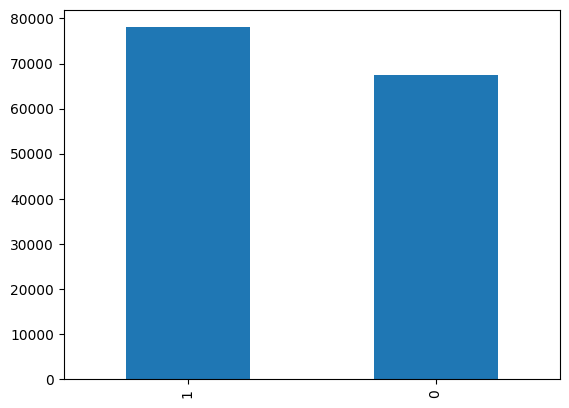

In [ ]:
print_plot(Total_train,'label')

In [ ]:
# 행 섞기
Total_train = Total_train.sample(frac=1).reset_index(drop=True)
Total_train

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,101,8995,12508,23811,9672,51431,9568,119121,12092,23665,...,0,0,0,0,0,0,0,0,0,0
1,101,9711,118611,10739,9672,18392,9297,17730,9641,24989,...,0,0,0,0,0,0,0,0,0,0
2,101,9708,119235,9682,119192,80046,9255,14843,118817,100,...,0,0,0,0,0,0,0,0,0,0
3,101,9568,118989,22333,118813,37712,19855,61844,10197,110,...,30873,25503,9032,11287,8881,119439,9960,12424,9768,1
4,101,137,9487,96279,27654,8924,118866,9205,11489,9266,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145441,101,122,131,11524,9256,16985,9543,878,119398,101322,...,0,0,0,0,0,0,0,0,0,1
145442,101,76854,11287,8910,54015,105197,134,62592,11018,9644,...,0,0,0,0,0,0,0,0,0,0
145443,101,137,160,14703,156,100,136,8888,118823,136,...,0,0,0,0,0,0,0,0,0,0
145444,101,79633,41521,9645,18108,11664,79633,41521,9266,54355,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
labels = Total_train['label']
Total_train2 = Total_train.drop(['label'], axis=1)
labels = pd.DataFrame(labels)
type(labels)

pandas.core.frame.DataFrame

In [ ]:
Total_train3 = Total_train2.to_numpy()
Total_train3[0]

array([   101,   8995,  12508,  23811,   9672,  51431,   9568, 119121,
        12092,  23665,  89523,  11664,    102,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
type(Total_train3)

numpy.ndarray

In [ ]:
#

In [ ]:
# input_ids
# train_all

In [ ]:
# 어텐션 마스크

attention_masks = []

for seq in Total_train3:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
labels

,label
0,0
1,0
2,0
3,1
4,0
...,...
145441,1
145442,0
145443,0
145444,1


In [ ]:
# train - validation set 분리

train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(Total_train3, labels.values, random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       Total_train3,
                                                       random_state=42, 
                                                       test_size=0.2)

In [ ]:
print(len(train_inputs))
print(len(validation_inputs))

116356
29090


In [ ]:
#

In [ ]:
test_test

,id,document,label
0,12064,@battle_g Wi 뭐라고 짖어대는지 모르겠다,0
1,26113,@구민수 응 너 개발림ㅋ,0
2,49541,나처럼 살까봐 낳기 싫다,0
3,34790,여가부나 없애라,0
4,32138,@아아아 뭐 이렇게 똥을 정성스럽게 싸놨어??? 북유럽 출산율 높아. 똥쌀거면 ...,0
...,...,...,...
6022,54000,@페튜니아petunia 생각이 없는듯 공무원들도 돈없는데 5급이상아니면 공무원이...,1
6023,5246,나라 망하던가.. 내알바냐,1
6024,47309,Meldy 11 청년 실업자수= 자살율,1
6025,45734,"국민들은 당장 살기도 바쁘고 힘든데 애낳고 기를 돈과 시간이 어딨음ㅋㅋ,,, 지들이...",1


In [ ]:
test_test = test_test.sample(frac=1).reset_index(drop=True)
test_test

,id,document,label
0,33499,자신이 가난한 것은 죄가 아니다그런데 애한테 자신의 가난함을 물려주는 것은 죄다차라...,1
1,14248,명확한 증거도 없이 표장장 위조 혐의로 4년 받는 나라임.,0
2,7773,뭔 출산률이랑 일진이랑 연관되는지...ㅋㅋㅋㅋ 입시는 어느나라나 경쟁은 있습니다. ...,1
3,41471,끝까지 노동문화나 기업이나 부동산이야기이야는 안꺼내죠 ㅋㅋㅋㅋ,1
4,11316,예전엔 개천에서 용이 등장했고 열심히 하면 부자될 수 있다 이런 희망이 있었음그런데...,0
...,...,...,...
6022,3271,대한민국 법 아래 결혼 조차 안하려들며 출산 생각도 안한다는 점 우리 이이들...,1
6023,815,문재인은 50조 걷고 또 50조원 걷어서 한게 뭐냐 ...,0
6024,15816,@이현우 대깨문은 하나하나 다 설명해줘야되누.. 민주당 시절 집값 쌉오지게 오른...,0
6025,1523,ㄴㄴ 제도: 최저임금은 6000원이 적당한듯 ㅇㅇ,1


In [ ]:
# Torch Tensor

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
# 배치 및 데이터로더 설정

BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [ ]:
print(len(train_data))
print(len(validation_data))
print(len(train_dataloader))
print(len(validation_dataloader))

116356
29090
3637
910


In [ ]:
# Original Test data 

sentences = test_test['document']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test_test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
# GPU checking, allocation

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 3070 Laptop GPU


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Optimizer

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# epochs
epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Accuracy

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
t00 = time.time()
print(time.strftime('%c', time.localtime(time.time())))

# Random seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Initializing gradient
model.zero_grad()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()
        
    for step, batch in enumerate(train_dataloader):
        
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        
        loss = outputs[0]
        
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()
        
        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


print("Test took: {:}".format(format_time(time.time() - t00)))

Mon Jan  2 16:35:45 2023

======== Epoch 1 / 4 ========
Training...
  Batch   500  of  3,637.    Elapsed: 0:02:09.
  Batch 1,000  of  3,637.    Elapsed: 0:04:18.
  Batch 1,500  of  3,637.    Elapsed: 0:06:27.
  Batch 2,000  of  3,637.    Elapsed: 0:08:36.
  Batch 2,500  of  3,637.    Elapsed: 0:10:45.
  Batch 3,000  of  3,637.    Elapsed: 0:12:54.
  Batch 3,500  of  3,637.    Elapsed: 0:15:03.

  Average training loss: 0.10
  Training epcoh took: 0:15:38

Running Validation...
  Accuracy: 0.98
  Validation took: 0:01:08

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  3,637.    Elapsed: 0:02:09.
  Batch 1,000  of  3,637.    Elapsed: 0:04:18.
  Batch 1,500  of  3,637.    Elapsed: 0:06:27.
  Batch 2,000  of  3,637.    Elapsed: 0:08:36.
  Batch 2,500  of  3,637.    Elapsed: 0:10:45.
  Batch 3,000  of  3,637.    Elapsed: 0:12:54.
  Batch 3,500  of  3,637.    Elapsed: 0:15:03.

  Average training loss: 0.05
  Training epcoh took: 0:15:38

Running Validation...
  Accuracy: 0.99


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

t00 = time.time()
print(time.strftime('%c', time.localtime(time.time())))

# Test evaluation
print(time.strftime('%c', time.localtime(time.time())))
pred_collection = np.array([])
label_collection = np.array([])

t0 = time.time()

model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):
    
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
        
    pred_flat_M = np.argmax(logits, axis=1).flatten()
    labels_flat_M = label_ids.flatten()
    
    pred_collection = np.concatenate((pred_collection, pred_flat_M))
    label_collection = np.concatenate((label_collection, labels_flat_M))
    
    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    
print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print("pred_collection : ",len(pred_collection))
print("label_collection : ",len(label_collection))
print(confusion_matrix(pred_collection, label_collection))
print(classification_report(pred_collection, label_collection))

print("Time took: {:}".format(format_time(time.time() - t00)))

Mon Jan  2 17:42:53 2023
Mon Jan  2 17:42:53 2023
  Batch   100  of    189.    Elapsed: 0:00:08.

Accuracy: 0.96
Test took: 0:00:14
pred_collection :  6027
label_collection :  6027
[[2984  225]
 [  30 2788]]
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      3209
         1.0       0.93      0.99      0.96      2818

    accuracy                           0.96      6027
   macro avg       0.96      0.96      0.96      6027
weighted avg       0.96      0.96      0.96      6027

Time took: 0:00:14
